Onyl run using `sim_class_improvements` branch with dx, dz available for Scalar

In [2]:
%cd Fatiando
%cd ..

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects


In [3]:
from PIL import Image
import numpy as np
img = Image.open('wedge.tif')
img.load()
img = img.convert('I') # gray scale, convert format
data  = np.asarray(img, dtype=np.float32)
data[:][data[:] == 255.] = 2500.0 # overburden
data[:][data[:] == 0. ] = 3500 # the triangle
data[:][data[:] == 146.] = 2300.0 # the first slab bellow the triangle
data[:][data[:] == 36.] = 2700.0 # the last slab
cshape = data.shape
print cshape

(160, 400)


Populating the interactive namespace from numpy and matplotlib


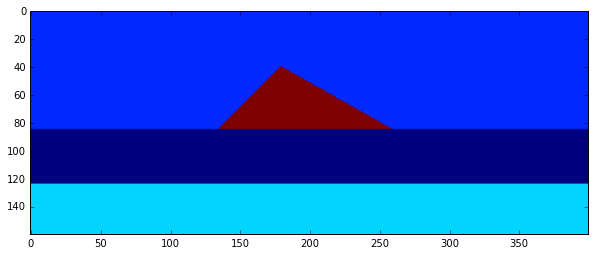

In [4]:
%pylab inline
figure(figsize(10,10))
imshow(data)

### Simulation parameters ###

To guarantee stability we have to avoid:

1. Spatial alias

In the simulation the maximum wave number is defined as $k_{max}$, from plane waves $ v =\lambda f$

$$ k_{max}(f,v) = \frac{f_{max}}{v_{min}} $$

So the maximum source frequency allowed to avoid spatial alias should be, from $k_{nyquest} = \frac{1}{2ds}$:

$$ f_{max} \leq v_{min} . \min\left( \frac{1}{2dz}, \frac{1}{2dx} \right) $$

We can garantee that with $\epsilon \leq 1. $ and 

$$ f_{max} = \epsilon . v_{min} . \min\left( \frac{1}{2dz}, \frac{1}{2dx} \right) $$

2. Alford et al. recommends for less numerical dispersion (2nd order time and 4th space) that the number

of points to describe the smaller wave lenght be always greater than five.

$$ P_{\lambda} = \frac{v_{min}}{f_{max} \max(dx, dz)} \geq 5.0$$

Joining stuff togueter we get:

$$ \epsilon \leq \frac{1}{5.0 \max(dx, dz)\min\left( \frac{1}{2dz}, \frac{1}{2dx} \right)} $$

So works for:

$$ \epsilon = 0.98 \frac{1}{5.0 \max(dx, dz)\min\left( \frac{1}{2dz}, \frac{1}{2dx} \right)} $$


If you want use a smaller frequency then $ f_{max} $ it's surelly better! 


$ f_{max} $ is just the maximum allowed frequency in your source to garantee 5 grid points per wavelenght




========================================================================================

For Gauss source the spectrum is really controled by fc (the highest frequency)

But for Ricker no!! fc is the central frequency!  (take a look at ffts to clarify)

So for Ricker wavelet the peak frequency might be determined by following:
(di bartollo)

Based on the maximum frequency desired $f_{cut}$

$$ fc = \frac{2f_{cut}}{3\sqrt{\pi}} $$

and time delay by the following:

$$ t_d = \frac{1}{f_c} $$

In [10]:
%cd Fatiando
from fatiando.seismic import wavefd
# Set the parameters of the finite difference grid
dx = 50. # spacing
dz = 25.
velocity = data
# avoiding spatial alias and less numerical dispersion based on plane waves v=l*f and Alford et al.
# we are using 5
eps = 0.98*1./(5*max(dx, dz)*min(1./(2*dx),1./(2*dz)))
fc = eps*np.min(velocity)/(max(2*dx, 2*dz))  
# fc for a Ricker wavelet to garante the maximum fc above 
fricker = (2./3.)*fc/np.sqrt(np.pi)
sim = wavefd.Scalar(velocity, (dx, dz))
sim.add_point_source((100, 3), wavefd.Ricker(1., fricker, delay=1./fricker))
print fc, np.min(velocity)/(fc*max(dx,dx)), eps, sim.dt
print velocity.shape

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
9.016 5.10204081633 0.392 0.00433034793813
(160, 400)


We used a Ricker but it's not a zero phase impulsive source. 

Our source is a bandlimited non-impulsive source (minimum-phase)

The biggest problem is that to avoid numerical dispersion the frequency of our source is really low

producing a delay in the simulation until the peak of the function in this case is 0.295448488087 seconds

In samples that is equal to ~~ 68 samples that needs to be removed from our simulation to make it zero-phase

**So 68 samples needs to be removed. To make our data zero-phase!**

time shift (s) 0.295448488087  samples to shitft  68


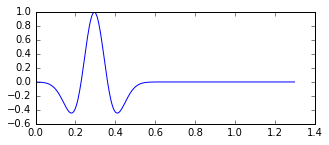

In [11]:
wf = wavefd.Ricker(1., fricker, delay=1./fricker)
t = np.linspace(0, 300*sim.dt, 300)
figure(figsize(5,2))
plot(t, wf(t))
print "time shift (s)", (t[wf(t).argmax()]), " samples to shitft ", wf(t).argmax()

In [12]:
sim.run(900)

|##################################################|100% Ran 900 iterations in 21.2924 seconds.

In [13]:
sim.dt*sim.simsize

3.897313144321092

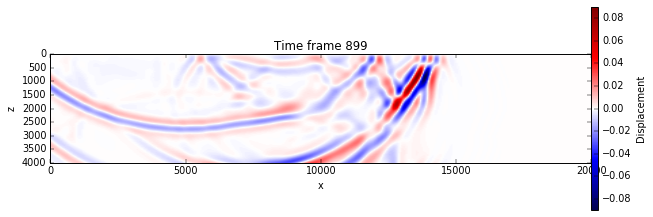

<function fatiando.seismic.wavefd.plot>

In [14]:
sim.explore()

In [9]:
#sim.animate(every=5, cutoff=1, blit=True, fps=20, dpi=50, embed=True, writer='ffmpeg')

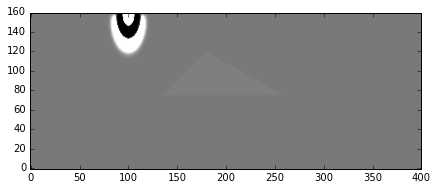

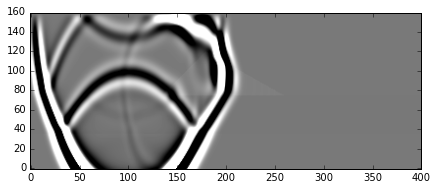

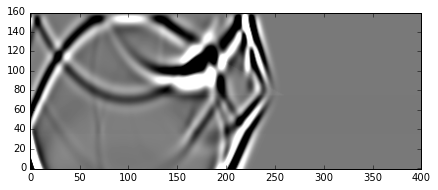

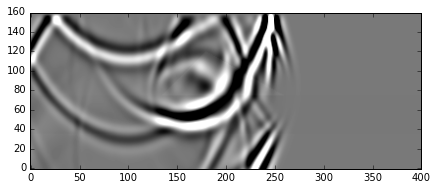

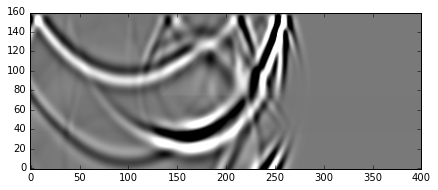

In [15]:
# that's default image size for this interactive session
def pstep(iter):     
    figure(figsize=(7, 7))     
    background = (velocity-3500)*10**(-6.0)         
    imshow((-background+sim[iter])[::-1], cmap=mpl.cm.gray_r, vmin=-.02, vmax=.02, origin='lower')  
pstep(104)
pstep(504)
pstep(650)
pstep(750)
pstep(800)

The numerical dispersion not very present anymore!

In the future try high order finite diferences in time and space like lax wendroff.

Plot the resulting shot getting it from seismograms at every position

## The simulation class througth the hdf5 file stores every iteration time step ##

In [13]:
#sim[:].shape

####Gathering traces to assembly a shot####
Reading the hdf5 file

Simulation dimensions (160, 400)

Starting at x=150 to x=200 : 100 Traces

Enhancement for seismic_wiggle: include a automatic parameter clip that ignores amplitudes above certain value (clipping it to zero, like Promax, SPW).

That clip parameter can be calculated based on the wiggle displacement allowed for not destroying neighbors traces on the plot window.

In [14]:
%cd Fatiando

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


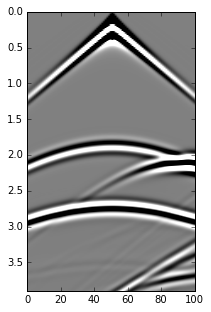

In [16]:
# if I want 400 I just could have those but I just want to look at 100 traces
from fatiando.vis import mpl

sx = 50
shot = np.zeros((900, 100))
shot[:, :] = sim[:, 3, sx:sx+100] # TODO: fix boundary/padding to avoid loosing 2 indexes due 4order space
# needed indexes for calculation

figure(figsize=(3,5))
#mpl.seismic_wiggle(shot, dt=sim.dt, scale=350.)
mpl.seismic_image(shot, dt=sim.dt, aspect='auto', vmin=-0.01, vmax=0.01)

##*Lets make a seismic acquisition (100 shots)*##

###Split Spread stack array (shotting between stations)###

dimensions:

(z160, x400) dx = 50 m ; dz = 25 m

Starting shotting at index = 100 = 100*dx = 5000 m

Dx_shot = indexes = 2 = 100 m // Dx_station = index = 2 = 100 m 

**  Shotting 100 shots **
  
**  70 stations **
  
**  30 fold **

*Stack array*

min offset = 50 m 
max offset = 50 m + 100*35 m = 3550 m

Model : maximum depth is 160*25 m = 4000 m

3550 max offset ~ close to 4000 m maximum depth rule of acquisition is 1 to 1 or 1.5 for 1 but it's okay

Average velocity of 2500 m/s will give TWT of (160*25./2500.)*2 = *3.2 seconds*

From the sample rate above (without alias etc.) we need 3.2/0.00433034793813 ~ *740 iterations*

To garantee sampling reflections of large offsets put to **900 iterations**

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Show the acquisition pattern ###

The expression bellow show all the x station coordinates grouped by shots

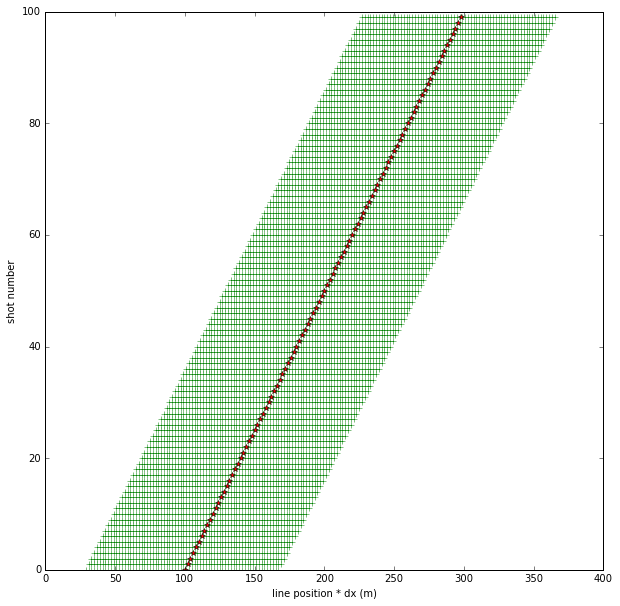

In [18]:
shots_x = [] # index x shot coordinates per shot
stations_x = [] # index x station coordinates per shot

for i in xrange(100):
    shot_x = 100 + 2*i
    station_0 = shot_x -1 -2*35 # first station (stack array)
    array_stations = [ station_0 + 2*i for i in xrange(70) ] # dx_shot = dx_station
    shots_x.append(shot_x) 
    stations_x.append(array_stations)

dummy = np.zeros(70)
figure(figsize=(10,10))

for i in xrange(100):
    plot(stations_x[i], dummy+i, 'g+')  # stations
    plot(shots_x[i], i, 'r*')  # source

ylabel("shot number")
xlabel("line position * dx (m)")
pylab.show()

In [29]:
from fatiando.seismic import wavefd
# Set the parameters of the finite difference grid dx = 50. spacing 
dx = 50
dz = 25. 
velocity = data 
# avoiding spatial alias and less numerical dispersion based on plane waves v=l*f and Alford et al. 
eps = 0.98*1./(5*max(dx, dz)*min(1./(2*dx),1./(2*dz))) 
fc = eps*np.min(velocity)/(max(2*dx, 2*dz))  
# for Gauss source the spectrum is really controled by fc (the highest frequency)
# But for Ricker no!! fc is the central frequency! So fc/2 gives 
# approximately fc as the highest frequency for a Ricker wavelet (take a look at ffts to clarify)
fc = fc/2. # for use with Ricker wavelet

def rum_sim_shot(source_array, iter=900):
    source_x, array_stations = source_array
    sim = wavefd.Scalar(velocity, (dx, dz))     
    sim.add_point_source((source_x, 3), wavefd.Ricker(1., fc, 1./fc))   
    sim.run(iter)
    # getting seismograms at zindex=3 or 3*25= 75 meters :-( TODO:
    return sim[:, 3, array_stations] # TODO: same as above padding/boundary etc..

### A simple test shot ###

Testing the function that will run in multiprocessing

In [30]:
print 'shot position: ', shots_x[0]
print 'stations: ', stations_x[0]

shot position:  100
stations:  [29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167]


In [31]:
%timeit
shot0 = None
shot0 = rum_sim_shot((shots_x[0], stations_x[0]))

|##################################################|100% Ran 900 iterations in 21.107 seconds.

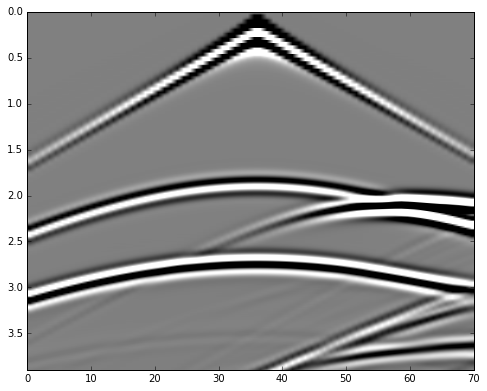

In [33]:
from fatiando.vis.mpl import seismic_image

figure(figsize=(8,10))
seismic_image(shot0, dt=sim.dt, vmin=-0.01, vmax=0.01)

## Running in parallel and creating all 100 shots ##

In [34]:
%timeit
from multiprocessing import Pool
print('Simulating...')
pool = Pool()
shots = pool.map(rum_sim_shot, zip(shots_x, stations_x))
pool.close()
print('Finished')

Simulating...
Finished


|###############################################---| 93%

####Plotting one of 100th shots####

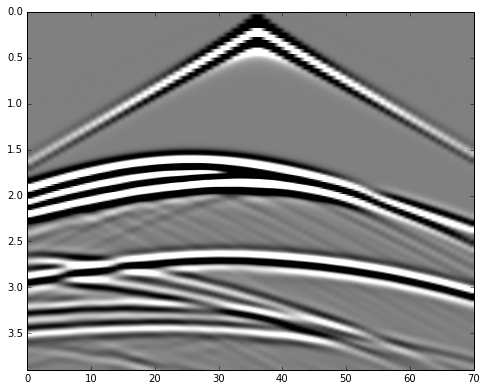

In [45]:
figure(figsize=(8,10))
seismic_image(shots[75], dt=sim.dt, vmin=-0.01, vmax=0.01)

##Creating pseudo zero-offset section##

using trace closer to source

In [ ]:
print shots[0].shape

In [ ]:
zeroffset = np.array([shots[i] for i in range(100)])

In [ ]:
print zeroffset.shape

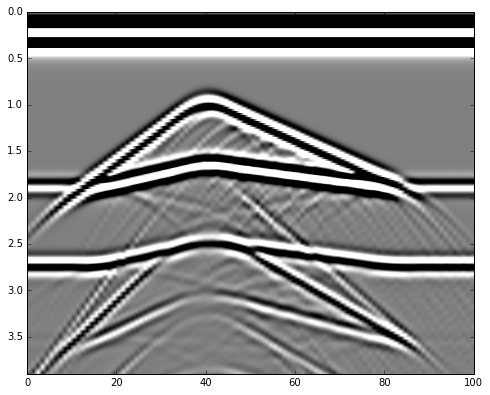

In [44]:
figure(figsize=(8,10))
seismic_image(zeroffset[:, :, 35].transpose(), dt=sim.dt, vmin=-0.01, vmax=0.01)

*Getting shots to save*

In [42]:
arrayshots = np.zeros((100, 900, 70))
for i in range(100):
    arrayshots[i] = shots[i]

|##################################################|100% Ran 900 iterations in 21.4217 seconds.

In [43]:
np.save('arrayshots_70s_900_07_12_2015', arrayshots)